## BETTER demo: Sentinel-1 radiometric and geometric correction with SNAP

Speckle-Filter filterSizeX

In [1]:
filterSizeX = '5'

Speckle-Filter filterSizeY

In [2]:
filterSizeY = '5'

Polarisation 

In [3]:
polarisation = 'VV'

Area of interest

In [4]:
wkt = 'POLYGON((68.03586 37.15143, 68.13586 37.15143, 68.13586 37.25143, 68.03586 37.25143, 68.03586 37.15143))'

In [5]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
sys.path.append('/opt/anaconda/bin/')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

In [6]:
data_path = '/workspace/data'

In [7]:
s1_identifier = 'S1A_IW_GRDH_1SDV_20170906T013058_20170906T013123_018248_01EADD_CC2A'

In [8]:
s1meta = "manifest.safe"

s1prd = os.path.join(data_path, s1_identifier, s1_identifier + '.SAFE', s1meta)

In [9]:
reader = ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1prd, None)

### ThermalNoiseRemoval step

In [10]:
HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()

parameters.put('selectedPolarisations', polarisation)
parameters.put('removeThermalNoise', 'true')
parameters.put('reIntroduceThermalNoise', 'false')

thermal_noise_removal = GPF.createProduct('ThermalNoiseRemoval', parameters, product)

## Apply-Orbit-File

In [11]:
parameters = HashMap()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'false')

apply_orbit_file = GPF.createProduct('Apply-Orbit-File', parameters, thermal_noise_removal)

## Calibration

In [12]:
parameters = HashMap()

parameters.put('auxFile', 'Product Auxiliary File')
parameters.put('outputImageInComplex', 'false')
parameters.put('outputImageScaleInDb', 'false')
parameters.put('createGammaBand', 'false')
parameters.put('createBetaBand', 'true')
parameters.put('selectedPolarisations', polarisation)
parameters.put('outputSigmaBand', 'false')
parameters.put('outputGammaBand', 'false')
parameters.put('outputBetaBand', 'true')

calibration = GPF.createProduct('Calibration', parameters, apply_orbit_file)

## Speckle-Filter

In [13]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s' % (polarisation))
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', filterSizeX)
parameters.put('filterSizeY', filterSizeY)
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')

speckle_filter = GPF.createProduct('Speckle-Filter', parameters, calibration)

## Terrain-Correction

In [14]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s' % (polarisation))
parameters.put('demName', 'SRTM 3Sec')
parameters.put('externalDEMFile', '')
parameters.put('externalDEMNoDataValue', '0.0')
parameters.put('externalDEMApplyEGM', 'true')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', '10.0')
#parameters.put('pixelSpacingInDegree', '8.983152841195215E-5')
parameters.put('mapProjection', 'AUTO:42001')
parameters.put('nodataValueAtSea', 'true')
parameters.put('saveDEM', 'false')
parameters.put('saveLatLon', 'false')
parameters.put('saveIncidenceAngleFromEllipsoid', 'false')
parameters.put('saveProjectedLocalIncidenceAngle', 'false')
parameters.put('saveSelectedSourceBand', 'true')
parameters.put('outputComplex', 'false')
parameters.put('applyRadiometricNormalization', 'false')
parameters.put('saveSigmaNought', 'false')
parameters.put('saveGammaNought', 'false')
parameters.put('saveBetaNought', 'false')
parameters.put('incidenceAngleForSigma0', 'Use projected local incidence angle from DEM')
parameters.put('incidenceAngleForGamma0', 'Use projected local incidence angle from DEM')
parameters.put('auxFile', 'Latest Auxiliary File')

terrain_correction = GPF.createProduct('Terrain-Correction', parameters, speckle_filter)

## Subset

In [15]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s' % (polarisation))
#parameters.put('region', '')
parameters.put('geoRegion', wkt)
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('tiePointGridNames', '')
parameters.put('copyMetadata', 'true')

subset = GPF.createProduct('Subset', parameters, terrain_correction)


## Garbage collector

In [16]:
thermal_noise_removal = None
apply_orbit_file = None
calibration = None
speckle_filter = None
terrain_correction = None

gc.collect()

0

## Save the result

In [17]:
ProductIO.writeProduct(subset, s1_identifier + '.tif', 'GeoTIFF')

## Plot the result

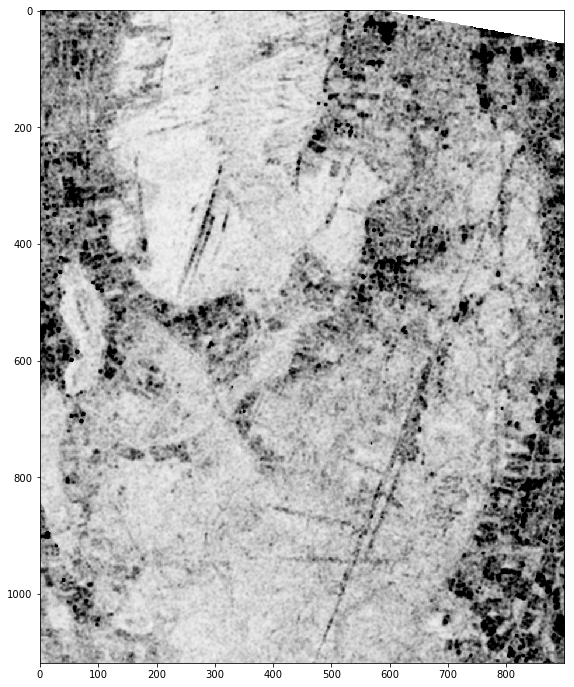

In [18]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(subset, 'Beta0_%s' % (polarisation), 0, 0.3)